## Chapter 15 – Processing Sequences Using RNNs and CNNs

## RNN 基础

### CTA芝加哥乘客数据分析

In [1]:
import tensorflow as tf

2023-11-24 09:14:31.716907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 09:14:31.791515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 09:14:33.032663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir='.',
    extract=True
)

'./datasets/ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
# 将数据框的列名更改为较短的形式，以提高代码的可读性。
df.columns = ["date", "day_type", "bus", "rail", "total"]
# 根据日期列对数据框进行排序，并将日期列设置为数据框的索引。
df = df.sort_values("date").set_index("date")
# no need for total, it's just bus + rail
df = df.drop("total", axis=1)
# remove duplicated months (2011-10 and 2014-07)
df = df.drop_duplicates()

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):  
让我们看一下2019年的前几个月（请注意，Pandas 将范围边界视为包含在内）。

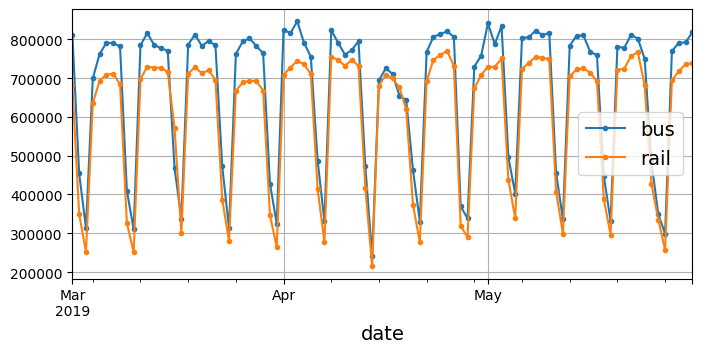

In [6]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

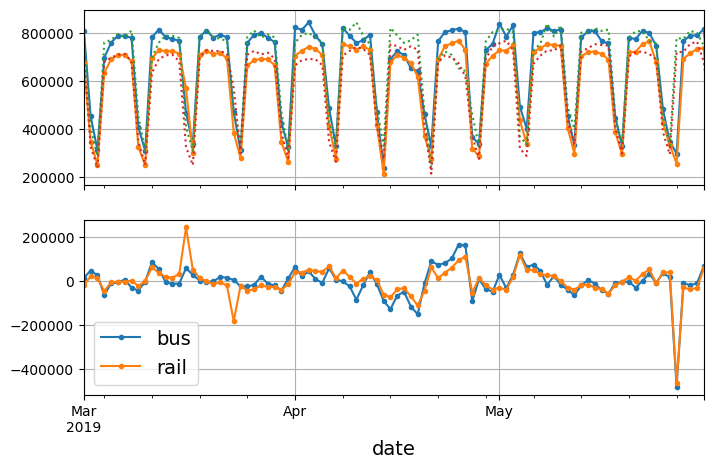

In [7]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":") # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".") # 7-day difference time series
axs[0].set_ylim([170_000, 900_000]) # extra code – beautifies the plot
plt.show()

这段代码主要用于生成时间序列数据的差分图，以便观察数据的趋势和周期性。以下是代码的详细解释：

1. **`diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]`：**
   - 使用 Pandas 的 `diff` 函数计算时间序列数据中每个时间点与其前面第 7 个时间点的差分。
   - `df[["bus", "rail"]]` 选择了数据框中的 "bus" 和 "rail" 两列。
   - `["2019-03":"2019-05"]` 表示在日期范围 2019 年 3 月至 2019 年 5 月之间进行计算。
   - 结果保存在 `diff_7` 中，包含了 "bus" 和 "rail" 列的 7 天差分时间序列。

2. **绘制差分图：**
   - 创建一个包含两个子图的图形，共享 x 轴。
   - 第一个子图 (`axs[0]`) 包括原始时间序列数据和滞后 7 天的时间序列数据。
   - 第二个子图 (`axs[1]`) 包括 7 天差分时间序列数据。

3. **`df.plot(ax=axs[0], legend=False, marker=".")`：**
   - 在第一个子图中绘制原始时间序列数据。
   - `legend=False` 表示不显示图例。
   - `marker="."` 表示在图中的每个数据点处标记一个小点。

4. **`df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")`：**
   - 在第一个子图中绘制滞后 7 天的时间序列数据。
   - `df.shift(7)` 将整个数据框向后移动 7 个时间点，以实现滞后效果。
   - `grid=True` 表示显示网格线。
   - `linestyle=":"` 表示使用虚线样式。

5. **`diff_7.plot(ax=axs[1], grid=True, marker=".")`：**
   - 在第二个子图中绘制 7 天差分时间序列数据。
   - `grid=True` 表示显示网格线。
   - `marker="."` 表示在图中的每个数据点处标记一个小点。

6. **`axs[0].set_ylim([170_000, 900_000])`：**
   - 在第一个子图中设置 y 轴的上下限，以美化绘图。
   - 这行代码用于调整 y 轴的显示范围。

综合起来，这段代码的目的是通过绘制原始时间序列数据、滞后时间序列数据以及时间序列数据的差分，来分析数据的趋势和周期性。这对于时间序列分析和预测中的数据探索性分析非常有用。

In [8]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):  
计算七天差分的绝对值的平均值。这可以提供一个关于七天差分波动的平均程度的指标

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

1. 选择2019年3月到2019年5月的bus和rail乘客数作为目标数据。
2. 计算七天差分相对于目标数据的绝对百分比误差的平均值。这可以提供一个关于七天差分相对于实际数据的平均误差程度的指标。

Now let's look at the yearly seasonality and the long-term trends:

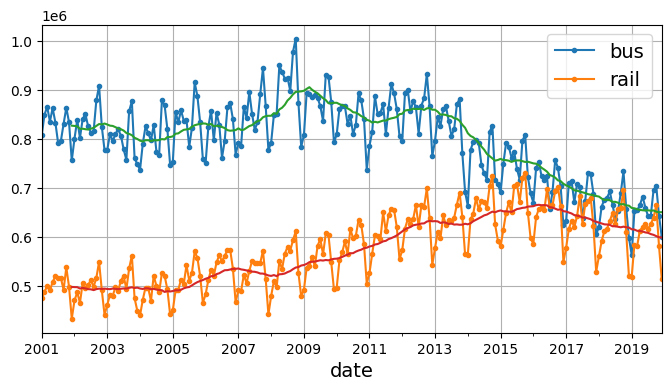

In [11]:
period = slice("2001", "2019")
df_monthly = df.drop("day_type", axis=1).resample('M').mean() # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

1. 使用resample方法将原始时间序列按月重采样，并计算每个月的平均值。这样可以获得一个新的时间序列，每个点代表每个月的平均乘客数。
2. 计算了12个月滚动平均值。这使用了rolling方法，它通过在窗口内取平均值来平滑时间序列，以更好地捕捉长期趋势。

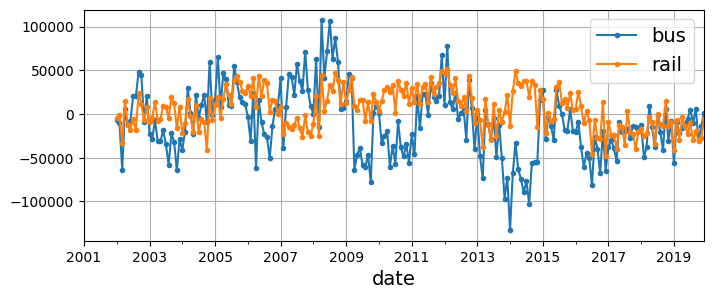

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

计算了每月平均乘客数的12个月差分，并绘制了这个差分的时间序列。这个差分的时间序列可以帮助你观察到每年同一时期的乘客数的变化趋势，因为它减去了一年前的值。

### 使用自回归模型 ARIMA 进行时间序列预测

In [13]:
# pip install -q -U statsmodels

In [14]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [15]:
y_pred[0]

427758.6263214406

这段代码使用了`statsmodels`库中的ARIMA模型（自回归移动平均模型）来进行时间序列预测。下面是对代码的详细解释：

1. `origin, today = "2019-01-01", "2019-05-31"`: 定义了时间序列数据的起始日期和结束日期。

2. `rail_series = df.loc[origin:today]["rail"].asfreq("D")`: 从原始数据框中选择了起始日期到结束日期之间的轨道乘客数数据，并使用`asfreq("D")`将时间序列的频率调整为每日。这是为了确保时间序列中没有间隔。

3. `model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))`: 创建了一个ARIMA模型。在这里，`order=(1, 0, 0)`表示ARIMA模型的自回归（AR）部分为1阶，不包含差分（差分次数为0），移动平均（MA）部分为0阶。`seasonal_order=(0, 1, 1, 7)`表示季节性ARIMA模型，季节差分次数为1，季节移动平均部分为1，季节长度为7天。

4. `model = model.fit()`: 使用数据拟合ARIMA模型，得到拟合好的模型。

5. `y_pred = model.forecast()`: 使用拟合好的模型进行预测，得到轨道乘客数在下一个时间点（在这里是未来一天）的预测值。这个预测值被存储在`y_pred`中。

总体来说，这段代码的目的是使用ARIMA模型对未来一天的轨道乘客数进行预测。ARIMA模型是一种常用于时间序列预测的统计模型，它结合了自回归、差分和移动平均的组合。如果有进一步的问题或需要更多解释，请随时提问。

In [16]:
df["rail"].loc["2019-06-01"] # target value

379044

In [17]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                 order=(1, 0, 0),
                 seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.72009386125

这段代码是在一个滑动窗口内使用ARIMA模型进行时间序列预测的过程，具体解释如下：

1. `origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"`: 定义了起始日期、开始日期和结束日期。

2. `time_period = pd.date_range(start_date, end_date)`: 创建了一个日期范围，从开始日期到结束日期，这个范围用于滑动窗口的迭代。

3. `rail_series = df.loc[origin:end_date]["rail"].asfreq("D")`: 选择了起始日期到结束日期之间的轨道乘客数数据，并将其频率调整为每日。

4. `y_preds = []`: 初始化一个空列表，用于存储每天的轨道乘客数预测值。

5. `for today in time_period.shift(-1):`: 遍历时间范围的每一天（由`shift(-1)`表示向前偏移一天）。

   - `model = ARIMA(rail_series[origin:today], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))`: 对每个时间点建立ARIMA模型，训练数据包括从起始日期到当前日期的所有数据。这里每天都重新训练模型，以便使用最新的数据进行预测。

   - `model = model.fit()`: 对模型进行拟合。

   - `y_pred = model.forecast()[0]`: 使用拟合好的模型进行一天的轨道乘客数预测。

   - `y_preds.append(y_pred)`: 将预测值添加到列表中。

6. `y_preds = pd.Series(y_preds, index=time_period)`: 将预测值列表转换为Pandas的Series对象，并设置日期范围为时间范围。

7. `mae = (y_preds - rail_series[time_period]).abs().mean()`: 计算预测值与实际值之间的平均绝对误差（MAE）。MAE是对模型预测误差的一种度量。

这段代码的目的是在滑动窗口内，每天都使用ARIMA模型重新训练，并预测未来一天的轨道乘客数。然后计算这些预测值与实际值之间的平均绝对误差。如果有任何疑问或需要更多解释，请随时提问。

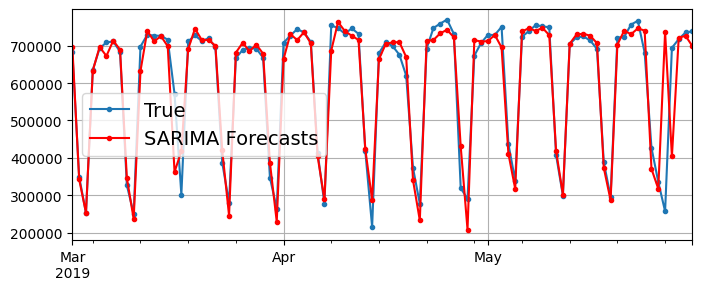

In [19]:
# displays the SARIMA forecasts

fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

这段代码用于可视化轨道乘客数的真实值和使用SARIMA模型进行的预测值。

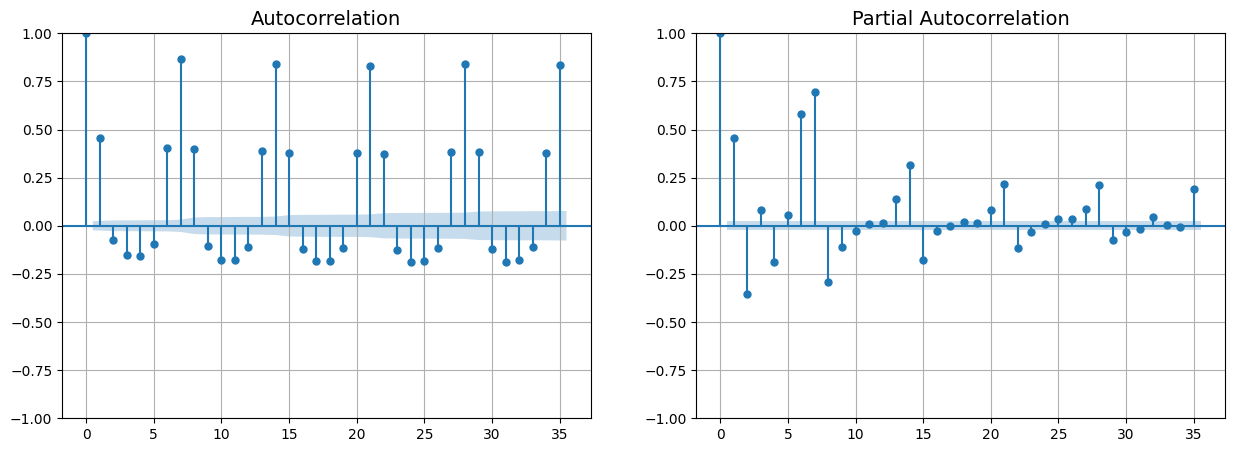

In [20]:
# show how to plot the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

这段代码是用于绘制轨道乘客数时间序列的自相关函数（ACF）和偏自相关函数（PACF）。这些函数对于了解时间序列数据的自相关性和部分自相关性非常有用。下面是对代码的详细解释：

1. `from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`: 引入`statsmodels`库中用于绘制自相关函数和偏自相关函数的函数。

2. `fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))`: 创建一个包含两个子图的图形对象，用于绘制ACF和PACF。

3. `plot_acf(df[period]["rail"], ax=axs[0], lags=35)`: 在第一个子图上绘制轨道乘客数时间序列的ACF。`lags=35`表示只绘制滞后35期的自相关系数。

4. `axs[0].grid()`: 在第一个子图上添加网格。

5. `plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")`: 在第二个子图上绘制轨道乘客数时间序列的PACF。`lags=35`表示只绘制滞后35期的偏自相关系数。`method="ywm"`表示使用 Yule-Walker 方程来计算偏自相关系数。

6. `axs[1].grid()`: 在第二个子图上添加网格。

7. `plt.show()`: 显示绘制的图形。

ACF和PACF是在时间序列分析中用于确定时间序列模型阶数（例如ARIMA模型阶数）的重要工具。通过观察这些图，你可以了解时间序列数据中的自相关性和部分自相关性的模式，从而选择适当的模型参数。

### 使用 TF 创建时间序列数据

In [21]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

这段代码使用TensorFlow的`timeseries_dataset_from_array`函数创建了一个时间序列数据集。让我来解释一下：

1. `my_series = [0, 1, 2, 3, 4, 5]`: 定义了一个简单的时间序列数据。

2. `my_dataset = tf.keras.utils.timeseries_dataset_from_array(`: 使用`timeseries_dataset_from_array`函数创建一个时间序列数据集。

   - `my_series`: 输入的时间序列数据。

   - `targets=my_series[3:]`: 目标值是时间序列数据向前偏移3个步长的结果。这样，数据集中的每个样本都是长度为3的输入序列和相应的目标值。

   - `sequence_length=3`: 指定输入序列的长度。

   - `batch_size=2`: 指定批次大小，即每个批次中包含的样本数。

3. `list(my_dataset)`: 将数据集转换为列表并打印出来。这样你可以查看数据集中的样本。

这段代码的目的是演示如何使用TensorFlow创建一个时间序列数据集，其中每个样本包含一个长度为3的输入序列和相应的目标值。这种数据集的构建对于训练循环神经网络（RNN）等模型非常有用。

In [22]:
for windows_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in windows_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2023-11-24 09:14:45.918364: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


这段代码使用 TensorFlow 的 `tf.data.Dataset` 创建一个窗口数据集，并展示了如何遍历这个窗口数据集中的子序列。让我解释一下：

1. `for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):`: 创建一个范围为 `[0, 1, 2, 3, 4, 5]` 的数据集，并使用 `window` 方法创建窗口数据集。这个窗口数据集的每个窗口包含 4 个元素，且窗口之间的移动步长为 1。

2. `for element in window_dataset:`: 遍历每个窗口数据集中的元素。

3. `print(f"{element}", end=" ")`: 打印每个元素。

4. `print()`: 打印一个换行符，用于分隔窗口。

这种滑动窗口的迭代方式在处理时间序列数据时经常用到，例如用于准备序列数据供循环神经网络（RNN）等模型训练。

In [23]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


这段代码继续处理窗口数据集，但使用了 `flat_map` 和 `batch` 方法。让我解释一下：

1. `dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)`: 创建一个窗口数据集，每个窗口包含 4 个元素，窗口之间的移动步长为 1，`drop_remainder=True` 表示如果窗口的最后一部分不足 4 个元素，则将其丢弃。

2. `dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))`: 使用 `flat_map` 方法，将每个窗口数据集中的元素列表（每个窗口的数据）转换成一个扁平的数据集，然后使用 `batch(4)` 方法，将每个窗口的元素列表合并为一个大小为 4 的批次。

3. `for window_tensor in dataset:`: 遍历批次数据集中的每个窗口。

4. `print(f"{window_tensor}")`: 打印每个窗口。

这段代码的输出会是一个大小为 4 的滑动窗口，如下：

```
tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)
```

每个 `tf.Tensor` 表示一个大小为 4 的滑动窗口，包含了相应的元素。这种数据集的处理方式可以用于准备训练数据，例如用于循环神经网络（RNN）等模型。

In [24]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

这段代码定义了一个函数 to_windows，该函数接受一个数据集和一个窗口的长度，然后返回一个新的数据集，其中每个元素是一个窗口的输入序列和对应的目标值。

### 使用 TF Keras 训练乘客 railway 数据模型

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [25]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06"]

In [26]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

这样的数据集构建是为了在训练循环神经网络（RNN）等模型时使用，以便更好地利用时间序列的结构。

In [27]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 10ms/step - loss: 0.1239 - mae: 0.3805 - val_loss: 0.0095 - val_mae: 0.1068
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0111 - mae: 0.1096 - val_loss: 0.0056 - val_mae: 0.0812
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0093 - mae: 0.0973 - val_loss: 0.0052 - val_mae: 0.0783
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0079 - mae: 0.0879 - val_loss: 0.0049 - val_mae: 0.0754
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0075 - mae: 0.0863 - val_loss: 0.0046 - val_mae: 0.0742
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0069 - mae: 0.0820 - val_loss: 0.0038 - val_mae: 0.0669
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0064 - mae: 0.0807 - val_loss: 0.0042 - val_mae: 0.0684
Epoch 8/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0063 - 

In [30]:
# evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0379


37864.15979266167